<a href="https://colab.research.google.com/github/JonasHell/aml_monet/blob/main/Monet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/CINN

/content/gdrive/MyDrive/CINN


In [ ]:
!git clone https://github.com/JonasHell/aml_monet.git

Cloning into 'aml_monet'...
fatal: could not read Username for 'https://github.com': No such device or address


In [2]:
pip install git+https://github.com/VLL-HD/FrEIA.git

  Cloning https://github.com/VLL-HD/FrEIA.git to /tmp/pip-req-build-qp3ppg1t
  Running command git clone -q https://github.com/VLL-HD/FrEIA.git /tmp/pip-req-build-qp3ppg1t


In [8]:
#################
# Architecture: #
#################
img_size  = 112
cond_size = 224

#############################
# Training hyperparameters: #
#############################
N_epochs    = 10
lr          = 1e-3
batch_size  = 16

#Total number of images used for training
N_train     = 64

#We take the first N_test images from the test dataset for validation and the N_val images after that for validation
N_test      = 64
N_val       = 64

if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
    
#######################
# Dataset parameters: #
#######################

#Root folder for dataset
data_root = '/content/gdrive/MyDrive/Daniel-Daten/'

#The code expects the images in the training and test folders to be named real1.jpg, real2.jpg, ..., fake1.jpg, fake2.jpg, ...
training_img_folder    =  data_root + 'cyclegan train/fake/'
training_cond_folder   =  data_root + 'cyclegan train/real/'
test_img_folder        =  data_root + 'cyclegan test/fake/' 
test_cond_folder       =  data_root + 'cyclegan test/real/'

########################
# Display and logging: #
########################

output_root = '/content/gdrive/MyDrive/CINN/'
output_image_folder     = output_root + 'images'

#######################
# Saving checkpoints: #
#######################

#This is where the training algorithm stores the model
model_output = output_root + 'monet_cinn.pt'
#This is where the evaluation algorithm reas the model from
model_path   = model_output

In [9]:
import numpy as np
from skimage import io, color
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as T
import albumentations

"""
Implement dataset for pytorch dataloader that returns source images as well as condition images
and create training and test dataloaders.

Remember to:
- Set correct paths to images
- Adapt image size and data augmentation to your needs
"""

"""
Custom dataset for holding photo + artistic rendering of photo pairs of RGB images
Supports:
-   cropping images to desired size (128 pixels x 128 pixels by default)
-   normalising images
-   data augmentation
-   adding noise to training data

Returns:
-   Tuples of source images with their respective condition images
"""

class PairDataset(Dataset):

  #Resize dataset, normalise data and augment if is_valid = 0
  def __init__(self, image_paths, condition_paths,  transform = True, noise = False, img_size = img_size, cond_size = cond_size, mean = (0, 0, 0), std  = (1, 1, 1)):
    self.image_paths        = image_paths
    self.condition_paths    = condition_paths
    #Check whether there is the same number of images and condition
    assert(len(image_paths) == len(condition_paths))
    self.img_size           = img_size
    self.cond_size          = cond_size
    self.transform          = transform
    self.noise              = noise


    if self.transform == False:
      self.img_aug = albumentations.Compose([
                                         albumentations.Resize(img_size, img_size, always_apply = True),
                                         albumentations.Normalize(mean, std, always_apply = True)
      ])
      self.cond_aug = albumentations.Compose([
                                         albumentations.Resize(cond_size, cond_size, always_apply = True),
                                         albumentations.Normalize(mean, std, always_apply = True)
      ])
    else:
      #Apply affine transformations to scale, shift and rotate input images
      self.img_aug = albumentations.Compose([
                                         albumentations.Resize(img_size, img_size, always_apply = True),
                                         albumentations.Normalize(mean, std, always_apply = True),
                                         albumentations.ShiftScaleRotate(shift_limit = 0.0625, 
                                                                         scale_limit = 0.1, 
                                                                         rotate_limit = 5,
                                                                         p = 0.9)
      ])
      #Apply affine transformations to scale, shift and rotate input images
      self.cond_aug = albumentations.Compose([
                                         albumentations.Resize(cond_size, cond_size, always_apply = True),
                                         albumentations.Normalize(mean, std, always_apply = True),
                                         albumentations.ShiftScaleRotate(shift_limit = 0.0625, 
                                                                         scale_limit = 0.1, 
                                                                         rotate_limit = 5,
                                                                         p = 0.9)
      ])

  def __len__(self):
    return len(self.image_paths)

  #Return tuple of image and its condition (another image)
  def __getitem__(self, index):
    #Open image and convert to numpy array 
    image = np.array(Image.open(self.image_paths[index]))
    image = self.img_aug(image = image)["image"]
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    image = torch.tensor(image, dtype = torch.float)
    if self.noise:
        image += 0.005 * torch.rand_like(image)

    #Open image and convert to numpy array 
    condition = np.array(Image.open(self.condition_paths[index]))
    condition = self.cond_aug(image = condition)["image"]
    condition = np.transpose(condition, (2,0,1)).astype(np.float32)
    condition = torch.tensor(condition, dtype = torch.float)
    if self.noise:
        condition += 0.005 * torch.rand_like(condition)

    return image, condition



training_img_list   =  [training_img_folder  + f'fake{i}.jpg' for i in range(1, 1 + N_train)]
training_cond_list  =  [training_cond_folder + f'real{i}.jpg' for i in range(1, 1 + N_train)]
test_img_list       =  [test_img_folder      + f'fake{i}.jpg' for i in range(1, 1 + N_test)]
test_cond_list      =  [test_cond_folder     + f'real{i}.jpg' for i in range(1, 1 + N_test)]
val_img_list        =  [test_img_folder      + f'fake{i}.jpg' for i in range(2 + N_test, 2 + N_test + N_val)]
val_cond_list       =  [test_cond_folder     + f'real{i}.jpg' for i in range(2 + N_test, 2 + N_test + N_val)]

train_data = PairDataset(training_img_list, training_cond_list, transform=True, noise=True)
test_data  = PairDataset(test_img_list, test_cond_list        , transform=False, noise=False)
val_data  =  PairDataset(val_img_list, val_cond_list          , transform=False, noise=False)


train_loader = DataLoader(train_data,   batch_size=batch_size, shuffle=True,    num_workers=8,  pin_memory=True, drop_last=True)
test_loader  = DataLoader(test_data,    batch_size=batch_size, shuffle=False,   num_workers=4,  pin_memory=True, drop_last=False)

#Load all test and validation images and append them to a list
#stack concatenates a sequence of tensors along a new dimension
#list creates a list using the __get_item__ function
x  = list(test_data)
tx = list(zip(*x))
test_img_all  = torch.stack(tx[0], 0).to(device)
test_cond_all  = torch.stack(tx[1], 0).to(device)

x  = list(val_data)
tx = list(zip(*x))
val_img_all  = torch.stack(tx[0], 0).to(device)
val_cond_all  = torch.stack(tx[1], 0).to(device)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


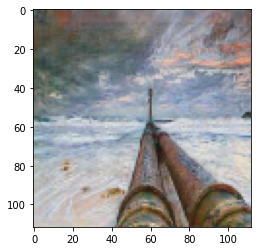

In [10]:
#Mit den folgenden Zeilen kann man den Code testen und sich den Effekt der Data Augmentation für das Trainingsdatenset anschauen

import matplotlib.pyplot as plt
%matplotlib inline
id = 32
img1, img2 = test_data[id]
plt.imshow(np.transpose(img1.numpy(), (1, 2, 0)))

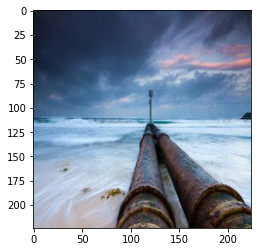

In [11]:
plt.imshow(np.transpose(img2.numpy(), (1, 2, 0)))

In [14]:
# %%
import torch
import torch.nn as nn
from torch.nn.modules.activation import ReLU
import torch.optim

import FrEIA.framework as Ff
import FrEIA.modules as Fm

# %%
ndim_total = 3*(img_size**2 + cond_size**2)

"""
            We are in layer 0
Output size: torch.Size([16, 128, 112, 112])
We are in layer 1
Output size: torch.Size([16, 256, 56, 56])
We are in layer 2
Output size: torch.Size([16, 512, 28, 28])
We are in layer 3
Output size: torch.Size([16, 512, 14, 14])
We are in layer 4
Output size: torch.Size([16, 512, 7, 7])
We are in layer 5
"""

class ConditionNet(nn.Module):
    def __init__(self):
        super().__init__()

        class Flatten(nn.Module):
            def __init__(self, *args):
                super().__init__()
            def forward(self, x):
                return x.view(x.shape[0], -1)

        self.res_blocks = nn.ModuleList([
            nn.Sequential(
                # 3 x 224 x 224
                nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                # 64 x 224 x 224
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                # 64 x 112 x 112
                nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                # 128 x 112 x 112, correct :)
            ),
            nn.Sequential(
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                # 128 x 56 x 56
                nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                # 256 x 56 x 56
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                # 256 x 56 x 56, correct :)
            ),
            nn.Sequential(
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                # 256 x 28 x 28
                nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                # 512 x 28 x 28
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                # 512 x 28 x 28, correct :)
            ),
            nn.Sequential(
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                # 512 x 14 x 14
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                # 512 x 14 x 14
                nn.ReLU(inplace=True),
                nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
                # 512 x 14 x 14, correct :)
            ),
            nn.Sequential(
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
                # 512 x 7 x 7, correct :)
            ),
            nn.Sequential(
                nn.AdaptiveAvgPool2d(output_size=(7, 7)),
                Flatten(),
                # 512 x 7 x 7
                nn.Linear(in_features=25088, out_features=4096, bias=True),
                # 4096
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5, inplace=False),
                nn.Linear(in_features=4096, out_features=4096, bias=True),
                # 4096
                #nn.ReLU(inplace=True),
                #nn.Dropout(p=0.5, inplace=False), # TODO: with dropout?
                #nn.Linear(in_features=4096, out_features=1000, bias=True)
                # 1000
            )
        ])
        
    def forward(self, photo):
        outputs = [photo]
        for i, module in enumerate(self.res_blocks):
            #print(f"We are in layer {i}")
            outputs.append(module(outputs[-1]))
            #print(f"Output size: {outputs[-1].size()}")
        return outputs[1:]

    # evtl auch möglich:
    # https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    # dann einfach in forward die entsprechenden unter module aufrufen, vermutlich baer ähnlich großer aufwand
        

class MonetCINN_112_blocks10(nn.Module):
    def __init__(self, learning_rate):
        super().__init__()

        self.cinn = self.create_cinn()
        self.cond_net = ConditionNet()

        self.trainable_parameters = [p for p in self.cinn.parameters() if p.requires_grad]
        for p in self.trainable_parameters:
            p.data = 0.02 * torch.randn_like(p)

        self.trainable_parameters += list(self.cond_net.parameters())
        self.optimizer = torch.optim.Adam(self.trainable_parameters, lr=learning_rate)

    def create_cinn(self):
    
        def subnet_conv(hidden_channels_1, hidden_channels_2, kernel_size):
            padding = kernel_size // 2
            return lambda in_channels, out_channels: nn.Sequential(
                nn.Conv2d(in_channels, hidden_channels_1, kernel_size, padding=padding),
                nn.ReLU(),
                nn.Conv2d(hidden_channels_1, hidden_channels_2, kernel_size, padding=padding),
                nn.ReLU(),
                nn.BatchNorm2d(hidden_channels_2),
                nn.Conv2d(hidden_channels_2, out_channels, kernel_size, padding=padding)
            )

        def subnet_fc(hidden_channels_1, hidden_channels_2):
            return lambda in_channels, out_channels: nn.Sequential(
                nn.Linear(in_channels, hidden_channels_1),
                nn.ReLU(),
                nn.Linear(hidden_channels_1, hidden_channels_2),
                nn.ReLU(),
                nn.Linear(hidden_channels_2, out_channels)
            )

        def add_stage(nodes, block_num, subnet_func, condition=None, split_nodes=None, split_sizes=None, downsample=True, prefix=''):
            """
            Convenience function that adds an entire stage to nodes.
            """
            #TODO: does appending work correctly?

            # add specified number of blocks
            for k in range(block_num):
                subnet = subnet_func(block_num)
                
                # add current block
                nodes.append(Ff.Node(
                    nodes[-1],
                    Fm.GLOWCouplingBlock,
                    {'subnet_constructor': subnet, 'clamp': 2.0},
                    conditions=condition, #TODO
                    name=prefix+f'-block{k+1}'
                ))

                # add permutation after each block
                nodes.append(Ff.Node(
                    nodes[-1],
                    Fm.PermuteRandom,
                    {},
                    name=prefix+f'-block{k+1}-perm'
                ))
            #print(nodes[-1])
            # split channels off
            if split_nodes is not None:
                nodes.append(Ff.Node(
                    nodes[-1],
                    Fm.Split,
                    {'section_sizes': split_sizes, 'dim': 0},
                    name=prefix+'split'
                ))
                split_nodes.append(Ff.Node(
                    nodes[-1].out1,
                    Fm.Flatten,
                    {},
                    name=prefix+'flatten'
                ))

            # add downsampling at the end of stage
            if downsample:
                nodes.append(Ff.Node(
                    nodes[-1],
                    Fm.HaarDownsampling,
                    {'rebalance': 0.5},
                    name=prefix+'-down'
                ))
            
        # create nodes with input node
        #nodes = [Ff.InputNode(3, 256, 256)]
        nodes = [Ff.InputNode(3, 112, 112)]

        # create conditions
        condition_nodes = [ Ff.ConditionNode(128, 112, 112),
                            Ff.ConditionNode(256, 56, 56),
                            Ff.ConditionNode(512, 28, 28),
                            Ff.ConditionNode(512, 14, 14),
                            Ff.ConditionNode(512, 7, 7),
                            Ff.ConditionNode(4096)] #TODO: 1000 or 4096?

        # create split_nodes
        split_nodes = []
        
        # stage 1
        # one block (3 x 112 x 112)
        # with conv3 subnet
        subnet_func = lambda _: subnet_conv(32, 64, 3)
        add_stage(nodes, 1, subnet_func,
            condition=condition_nodes[0],
            prefix='stage1'
        )

        # stage 2
        # two blocks (12 x 56 x 56)
        # one with conv1 and one with conv3 subnet
        subnet_func = lambda block_num: subnet_conv(64, 128, 3 if block_num%2 else 1)
        add_stage(nodes, 2, subnet_func,
            condition=condition_nodes[1],
            split_nodes=split_nodes,
            prefix='stage2'
        )

        # stage 3
        # two blocks (24 x 28 x 28)
        # one with conv1 and one with conv3 subnet
        subnet_func = lambda block_num: subnet_conv(128, 256, 3 if block_num%2 else 1)
        add_stage(nodes, 2, subnet_func,
            condition=condition_nodes[2],
            split_nodes=split_nodes,
            prefix='stage3'
        )

        # stage 4
        # two blocks (48 x 14 x 14)
        # one with conv1 and one with conv3 subnet
        subnet_func = lambda block_num: subnet_conv(128, 256, 3 if block_num%2 else 1)
        add_stage(nodes, 2, subnet_func,
            condition=condition_nodes[3],
            split_nodes=split_nodes,
            prefix='stage4'
        )
        #TODO: does it make sense to increase num of channels in subnets?
        #TODO: should they be larger in the beginning due to condition
        #print(nodes[-1])
        # stage 5
        # two blocks (96 x 7 x 7)
        # one with conv1 and one with conv3 subnet
        subnet_func = lambda block_num: subnet_conv(128, 256, 3 if block_num%2 else 1)
        add_stage(nodes, 2, subnet_func,
            condition=condition_nodes[4],
            downsample=False,
            split_nodes=split_nodes,
            split_sizes=[24, 72],
            prefix='stage5'
        )

        # flatten for fc part
        nodes.append(Ff.Node(
            nodes[-1],
            Fm.Flatten,
            {},
            name='flatten'
        ))

        # stage 6
        # one block (flat 1176)
        # with fc subnetwork
        subnet_func = lambda _: subnet_fc(1024, 1024)
        add_stage(nodes, 1, subnet_func,
            condition=condition_nodes[5],
            downsample=False,
            prefix='stage6'
        )
        #print(nodes[-1])
        # concat all the splits and the output of fc part
        nodes.append(Ff.Node(
            [sn.out0 for sn in split_nodes] + [nodes[-1].out0],
            Fm.Concat,
            {'dim':0},
            name='concat'
        ))
        #print(nodes[-1])
        # add output node
        nodes.append(Ff.OutputNode(nodes[-1], name='output'))
        #print(nodes[-1])
        #TODO: use GraphINN or ReversibleGraphNet??
        return Ff.ReversibleGraphNet(nodes + split_nodes + condition_nodes)

    def forward(self, monet, photo):
        return self.cinn(monet, c=self.cond_net(photo), jac=True)

    def reverse_sample(self, z, photo):
        return self.cinn(z, c=self.cond_net(photo), rev=True)

        # am ende fc? oder muss conv dann iwie so passen dass am ende was sinvolles rauskommt
        # muss latent space gleiche dim wie original space haben
        # welche dim müssen conditions haben
        # wieviel channel in subnet?

In [15]:
from time import time

#from tqdm import tqdm
import torch
import torch.optim
import numpy as np


"""
Training routine for INN
Remember to:
- Adapt number of epochs
- Set learning rate
- Set output directory for model
"""

cinn = MonetCINN_112_blocks10(lr)
cinn.to(device)
scheduler = torch.optim.lr_scheduler.StepLR(cinn.optimizer, 1, gamma=0.1)

N_epochs = N_epochs
t_start = time()
nll_mean = []

print('Epoch\tBatch/Total \tTime \tNLL train\tNLL val\tLR')
for epoch in range(N_epochs):
    for i, images in enumerate(train_loader):
        #train_loader returns a list with two elements
        #Both elements are torch tensors with size (batch_size x 3 (RGB channels) x image width x image height)
        #We immediately load every batch of source and condition images to the GPU
        source    = images[0].to(device)
        condition = images[1].to(device)

        #We pass both the source image as well as the condition image to the INN
        """
        This needs to be adapted depending on the final architecture of the INN
        """
        z, log_j = cinn(source, condition)

        #Compute the loss of the INN
        nll = torch.mean(z**2) / 2 - torch.mean(log_j) / ndim_total
        nll.backward()
        nll_mean.append(nll.item())
        cinn.optimizer.step()
        cinn.optimizer.zero_grad()

        #Print training progress every 20 batches
        if not i % 20:
            #Compute training loss for validation images
            with torch.no_grad():
                """
                This needs to be adapted depending on the final architecture of the INN
                """
                z, log_j = cinn(val_img_all, val_cond_all)
                nll_val = torch.mean(z**2) / 2 - torch.mean(log_j) / ndim_total

            print('%.3i \t%.5i/%.5i \t%.2f \t%.6f\t%.6f\t%.2e' % (epoch,
                                                            i, len(train_loader),
                                                            (time() - t_start)/60.,
                                                            np.mean(nll_mean),
                                                            nll_val.item(),
                                                            cinn.optimizer.param_groups[0]['lr'],
                                                            ), flush=True)
            nll_mean = []

    scheduler.step()
torch.save(cinn.state_dict(), model_output)

# %%


ReversibleGraphNet(
  (module_list): ModuleList(
    (0): GLOWCouplingBlock(
      (subnet1): Sequential(
        (0): Conv2d(129, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (subnet2): Sequential(
        (0): Conv2d(130, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): PermuteRandom()
    (2): HaarDownsampling()
    (3): GLOWCouplingBlock(
      (subnet1): Seque

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


000 	00000/00004 	0.05 	0.279008	0.272954	1.00e-03
001 	00000/00004 	0.13 	0.404005	0.245503	1.00e-04
002 	00000/00004 	0.22 	0.242626	0.242459	1.00e-05
003 	00000/00004 	0.30 	0.241659	0.242130	1.00e-06
004 	00000/00004 	0.39 	0.241367	0.242102	1.00e-07
005 	00000/00004 	0.47 	0.241355	0.242100	1.00e-08
006 	00000/00004 	0.56 	0.241373	0.242100	1.00e-09
007 	00000/00004 	0.64 	0.240959	0.242095	1.00e-10
008 	00000/00004 	0.73 	0.241287	0.242094	1.00e-11
009 	00000/00004 	0.81 	0.241052	0.242099	1.00e-12


In [76]:
m = nn.AdaptiveAvgPool2d((7,7))
input = torch.randn(16, 512, 7, 7)
output = m(input)
output.size()

torch.Size([16, 512, 7, 7])